In [51]:
# %pip install pandas spacy numpy transformers[torch] seaborn jupyter torch

In [2]:
import pandas as pd
import zipfile
import spacy
import re
import numpy as np
from transformers import pipeline
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
def getDataFrameFromZip(filename, folder=""):
    with zipfile.ZipFile(f"{folder}{'/' if folder != '' else ''}{filename}.zip", "r") as zipfolder:
        with zipfolder.open(f"{filename}.jsonl", "r") as jsonlfile:
            return pd.read_json(jsonlfile, lines=True)

In [4]:
df = pd.read_json("lemmas_maincategories_english_1k7.jsonl", lines=True)
wordlist = pd.read_csv("mannwhitney_wordlist_maincategories_1k7.csv")

In [5]:
df.head()

,responsedatetime,source,url,title,author,categories,datetime,text,lemmas,textenglish
0,2024-04-30 10:57:37,El Confidencial,https://www.elconfidencial.com/espana/2017-05-...,Pedro Sánchez gana con rotundidad las primaria...,None,[PSOE],2017-05-22 12:27:06,"Al 99,2% escrutado, los resultados de la web d...","{'escrutado': [9], 'resultado': [24, 3242, 379...","At 99.2%, the results of the PSOE website indi..."
1,2024-05-02 21:01:33,El Confidencial,https://www.elconfidencial.com/alma-corazon-vi...,'Chemsex': el fenómeno de drogas y sexo grupal...,None,[DROGAS],2017-06-05 12:18:00,"Consumo de todo tipo de estupefacientes, sexo ...","{'Consumo': [0], 'tipo': [16, 664], 'estupefac...","Consumption of all kinds of narcotics, non-sto..."
2,2024-04-30 10:46:01,El Confidencial,https://www.elconfidencial.com/medioambiente/c...,"""Estamos en la era de la ebullición"": la adver...",Jorge García González,[CAMBIO CLIMÁTICO],2023-07-28 10:04:00,El mes de julio de 2023 está camino de convert...,"{'mes': [3, 798, 2173], 'julio': [10, 1750, 19...",The month of July 2023 is on the way to becomi...
3,2024-05-02 21:02:49,El Confidencial,https://www.elconfidencial.com/espana/2023-11-...,La Policía baraja como hipótesis la autoría ir...,Alejandro Requeijo,[PP],2023-11-09 19:58:00,El exlíder del PP en Cataluña Alejo Vidal-Quad...,"{'exlíder': [3], 'PP': [15, 3341], 'Cataluña':...",The PP ex-leader in Catalonia Alejo Vidal-Quad...
4,2024-05-02 21:12:59,El Confidencial,https://www.elconfidencial.com/espana/madrid/2...,Ayuso anuncia una nueva estación de la Línea 9...,I. S. Calleja,[PP],2022-10-04 10:28:00,La Comunidad de Madrid proyecta ya una nueva e...,"{'Comunidad': [3, 1650], 'Madrid': [16, 671, 8...",The Community of Madrid already projects a new...


In [6]:
n=10

In [57]:
# !spacy download es_core_news_lg

In [7]:
nlp = spacy.load("es_core_news_lg")

In [8]:
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", top_k=None)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

c:\Users\Manuel Bonet\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Manuel Bonet\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [9]:
classifier("Let's go to the beach!")

[[{'label': 'positive', 'score': 0.7915487289428711},
  {'label': 'neutral', 'score': 0.20416341722011566},
  {'label': 'negative', 'score': 0.004287860356271267}]]

In [10]:
def score(text, labels, label_weights, *args, **kwargs):
    scoreDicts = classifier(text, *args, **kwargs)[0]

    partialScore = 0
    for scoreDict in scoreDicts:
        label = scoreDict["label"]
        score = scoreDict["score"]
        j = labels.index(label)
        weight = label_weights[j]
        partialScore = partialScore + score*weight
    return partialScore

In [20]:
def selectAndScore(row, wordlist, n, *args, **kwargs):
    textChunks = [] # [start, end)
    englishtextChunks = []

    for paragraph in re.finditer(r"^.*[^\s].*$", row["text"], re.MULTILINE):
        textChunks.append((paragraph.start(), paragraph.end()))
    
    for paragraph in re.finditer(r"^.*[^\s].*$", row["textenglish"], re.MULTILINE):
        englishtextChunks.append((paragraph.start(), paragraph.end()))
    
    categoryScores = {}
    categoryCounts = {}
    counts = np.zeros(len(textChunks), dtype=int)
    chunkScores = np.zeros(len(textChunks))

    for category in row["categories"]:
        for word in wordlist[category][0:n]:
            if word in row["lemmas"].keys():
                categoryCounts[category] = np.zeros(len(textChunks))
                for position in row["lemmas"][word]:
                    for i in range(len(textChunks)):
                        if textChunks[i][0] <= position and position < textChunks[i][1]:
                            categoryCounts[category][i] += 1
                            counts[i] += 1
    
    
    nonzeroCounts = np.nonzero(counts)[0]
    texts = []
    
    for i in nonzeroCounts:
        texts.append(row["textenglish"][englishtextChunks[i][0]:englishtextChunks[i][1]])

    if len(texts) != 0:
        chunkScores[nonzeroCounts] = score(texts, *args, **kwargs)
                            
    for category in categoryCounts.keys():
        categoryScores[category] = np.dot(categoryCounts[category], chunkScores)
    
    output = {}

    for category in row["categories"]:
        if not category in categoryCounts.keys():
            output[category] = np.nan
        elif np.sum(categoryCounts[category]) == 0:
            output[category] = np.nan
        else:
            output[category] = categoryScores[category]/np.sum(categoryCounts[category])
    
    return output

In [22]:
scoreNegPos = lambda text: selectAndScore(
    text,
    wordlist,
    n,
    labels=["negative", "neutral", "positive"],
    label_weights=[-1, 1, 0],
    truncation=True,
    padding=True,
    max_length=512
)

In [23]:
df["negpos"] = df.apply(scoreNegPos, axis=1)

In [24]:
df.to_json("scored_paragraphs_english_maincategories_1k7.jsonl", orient="records", lines=True)

In [25]:
def duplicateIfSeveralCategoriesHelper(row, dict):
    keys = ["responsedatetime", "source", "url", "title", "author", "category", "datetime", "text", "textenglish", "lemmas", "negpos"]

    for key in keys:
        if key not in dict.keys():
            dict[key] = []
    
    for category in row["categories"]:
        if pd.notna(row["negpos"]):
            for key in keys:
                if key == "category":
                    dict["category"].append(category)
                elif key == "negpos":
                    dict["negpos"].append(row["negpos"][category])
                else:
                    dict[key].append(row[key])

def duplicateIfSeveralCategories(df):
    dict = {}

    df.apply(lambda x: duplicateIfSeveralCategoriesHelper(x, dict), axis=1)

    return pd.DataFrame.from_dict(dict)

In [26]:
duplicateddf = duplicateIfSeveralCategories(df)

In [27]:
sns.displot(duplicateddf, x="negpos", stat="density", row="category", col="source")

In [178]:
def meandf(duplicateddf):
    categories = duplicateddf["category"].unique()
    sources = duplicateddf["source"].unique()

    array = np.zeros((len(categories), len(sources)))
    
    for i, category in enumerate(categories):
        for j, source in enumerate(sources):
            array[i,j] = np.mean(duplicateddf["negpos"].loc[(duplicateddf["category"]==category) & (duplicateddf["source"]==source)])

    return pd.DataFrame(array, index=categories, columns=sources)

<Axes: >

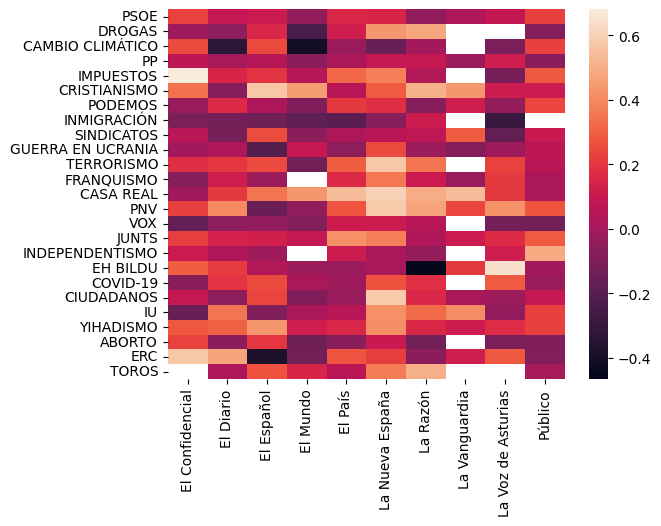

In [179]:
sns.heatmap(meandf(duplicateddf))